# Sentiment analysis : Movies review text in Finnish


## Data

The data is obtained from leffatykki.com. 

In [1]:
import pandas as pd
import numpy as np

# Read in the data
df1 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_1.csv')
df2 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_2.csv')
df3 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_3.csv')
df4 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_4.csv')
df5 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_5.csv')
df6 = pd.read_csv('C:/Users/meiye/Courses/python_appliedTextMining/dataFiles/leffatykki_reviews_6.csv')


df = pd.concat([df1, df2, df3, df4, df5, df6])

print(df.head())

print('\nOriginal data dimension : {}'.format(df.shape))

   Unnamed: 0  score                                               text  \
0           0   60.0  Scaramanga on kuuluisa palkkamurhaaja, jonka t...   
1           1   60.0  Avauskohtaus heti ikonisen gunbarrelin jälkeen...   
2           2   60.0  1973 valmistui kansan suosikki Bond Live And L...   
3           3   90.0  Vuonna 1995 saatiin valmiiksi uusi Bond-elokuv...   
4           4   90.0  Kuusi vuotta ehti kulua ja sinä aikana tapahtu...   

                                               title  
0   Parhaimmillaan kuitenkin oikein hyvää viihdettä.  
1                        Kokonaisuus on epätasainen.  
2  Toiminta on jonkun verran hakusessa, joka lask...  
3  Kultainen silmä kuuluu parhaimpiin Bond-elokuv...  
4                                         Hyvä Bond.  

Original data dimension : (16605, 4)


In [2]:
df['score'].plot.hist()


### Data preparation

1. Shuffle the rows of read in data.
2. Set score scale to (1 - 10). Original data has scale (10 - 100).
3. Drop rows that has empty review text.
4. Define binary sentiment classes (1 for positive; 0 for negative) based on score (1 - 3 as negative, 8 - 10 as positive, drop rows with score 4 - 7). From the histogram above, we can see we will have unbalanced data for the classes.


In [3]:
# shuffle df rows
df = df.sample(frac=1).reset_index(drop=True)

# set score to scale 1--10
df['score']=df['score']/10

# drop rows with NaN review text
df = df[df['text'].notna()]

# Remove 'neutral' ratings (score 4 -7)
df = df[(df['score'] < 4)|(df['score'] > 7) ]

# Encode 8, 9, 10 as 1 (Positive)
# Encode 1, 2, 3 as 0 (Negative)
df['Positively Rated'] = np.where(df['score'] > 7, 1, 0)

print(df.head())

print('\nDimension of the data after pre-processing : {}'.format(df.shape))

   Unnamed: 0  score                                               text  \
1        2066    9.0  Onpa jälleen Bond-maakarit murjasseet leffan. ...   
3         669    8.0  Nerokas elokuvaohjaaja Kevin Smith tunnetaan n...   
4        2803    9.0  Kotimainen sotaelokuva on aina tapaus. Sitä pi...   
5         875    9.0  Long ago in a distant land, I, Aku, the shape-...   
7        3162    8.0  Jeah, Elvis elää! Tätä mieltä on David Winkler...   

                                               title  Positively Rated  
1  Kuolema saa odottaa nousee ajan myötä jonkinmo...                 1  
3  Vaatii populaarikulttuuritietämystä sekä ymmär...                 1  
4  Tunteisiin vetoava elokuva sotiemme sankaritta...                 1  
5           Hauska, kekseliäs ja visuaalisesti upea.                 1  
7  Hieno, elämänmakuinen road movie. Remember the...                 1  

Dimension of the data after pre-processing : (9365, 5)


In [21]:
# Check portion of class 1
print('Proportion of data with positive rating (class 1) : {:.3f}%'.format(df['Positively Rated'].mean()*100,2))


Proportion of data with positive rating (class 1) : 85.318%


### Functions for model evaluation

In [115]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Function for printing MEAN ACCURACY and ROC_AUC_SCORE
#
def Score_Model(x_test, y_test, model):
    ## Print mean accuracy
    print('Mean accuracy : {:.3f}'.format(model.score(x_test, y_test)) )
    
    prediction_prob = model.predict_proba(x_test)

    ## Print ROC-AUC score
    print('ROC-AUC score : {:.3f}'.format(roc_auc_score(y_test, prediction_prob[:,1])) )
    
    
def Print_ConfMatrix(x_test, y_test, model):
    
    prediction = model.predict(x_test)
    
    ## generate and print confusion matrix
    #
    cm = confusion_matrix(y_test, prediction)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=["0","1"], yticklabels=["0","1"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

## Split data into training and test sets

In [6]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['Positively Rated'], 
                                                    random_state=7,
                                                    test_size=0.2)

## Logistic regression

Here we tranform the review text to word count vector representation and then generate tfidf matrix and fit to a logistic regression model. 

We choose to include words and bi-grams for generating the count vector and a minimum document frequency of 10. For training the logistic regression model, the C parameter is set to 0.6. The "balanced" option for the "class_weight" parameter since the data is quite unbalanced (85% to 15%) for the classes. 

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

model_logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), min_df = 10)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(C=0.6, class_weight='balanced')),
                    ]) 
model_logreg.fit(X_train, y_train)


C:\Users\meiye\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=No...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=0.6, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=

Mean accuracy : 0.942
ROC-AUC score : 0.967


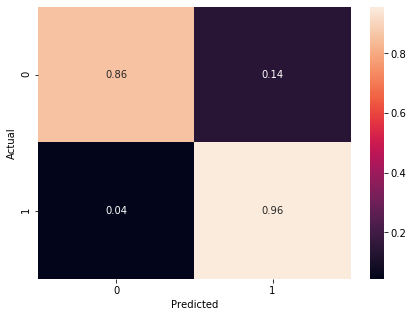

In [154]:
Score_Model(X_test, y_test, model_logreg)
Print_ConfMatrix(X_test, y_test, model_logreg)


### Examine features associated with the classes

In [11]:
logreg_vect = model_logreg.get_params()['vect']
logreg_clf = model_logreg.get_params()['clf']

# get the feature names as numpy array
feature_names = np.array(logreg_vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = logreg_clf.coef_[0].argsort()

# Find the 20 smallest and 20 largest coefficients
# The 20 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-21:-1]]))

Smallest Coefs:
['edes' 'sitten' 'mitään' 'huono' 'ei' 'surkea' 'olisi' 'juoni' 'ihan'
 'ilmeisesti' 'että' 'jos' 'vain' 'pahasti' 'oikein' 'minkäänlaista'
 'miksi' 'sentään' 'tylsä' 'valitettavasti']

Largest Coefs: 
['ja' 'myös' 'hyvin' 'hän' 'loistava' 'hieman' 'tekee' 'sekä' 'joka'
 'paras' 'elokuva' 'hänen' 'silti' 'hienosti' 'loistavasti' 'vaikka'
 'kaikille' 'ehdottomasti' 'toimii' 'hieno']


# Stoplist generation using mutual information based feature selection

We have tried using the stopword provided by sklearn CountVectorizer() which resulted in degraded performance. Instead of using standard stopwords list, mutual information based feature selection method is used here to select poor class discriminating variables as stoplist.

In [12]:
# Fit the CountVectorizer to the training data
vectX_train = CountVectorizer().fit(X_train)

len(vectX_train.get_feature_names())

258618

In [13]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vectX_train.transform(X_train)

X_train_vectorized

<7492x258618 sparse matrix of type '<class 'numpy.int64'>'
	with 1814192 stored elements in Compressed Sparse Row format>

In [14]:
from sklearn.feature_selection import mutual_info_classif as mi_classif

mi = mi_classif(X_train_vectorized, y_train)


In [16]:
mi_df = pd.Series(mi)

fea_df=pd.Series(vectX_train.get_feature_names())

fea_mi_df = pd.concat([fea_df, mi_df], axis=1, ignore_index=True)
fea_mi_df.columns=['feature', 'mi']
fea_mi_sorted= fea_mi_df.sort_values(by=['mi'], ascending=False)

print( 'Head : ', fea_mi_sorted.head(), '\nTail :', fea_mi_sorted.tail())

Head :         feature        mi
25507     edes  0.032238
134119    myös  0.017924
203302  surkea  0.017072
128036  mitään  0.015910
52086    huono  0.015778 
Tail :             feature            mi
81075         kerää  7.747123e-09
228695  tyypillisen  6.071876e-10
219946    toisenkin  6.071876e-10
138951      niskaan  6.071876e-10
193127    siirtynyt  6.071876e-10


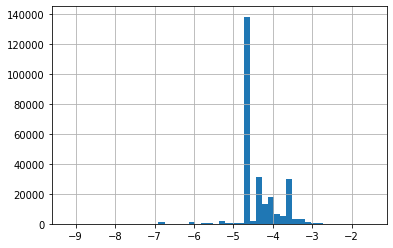

In [17]:
## Histogram of mutual information estimates between feature and target
#
np.log10(fea_mi_sorted['mi']).hist(bins=50)

From the histogram, features that give mutual information < 1e-5 will be included in the stopwords list.

In [18]:
stoplist_len = len(fea_mi_sorted[fea_mi_sorted.mi<1e-5])
stoplist=list(fea_mi_sorted.feature[-stoplist_len:-1])

### Re-train logistic regression classifier with words in stoplist as stopwords

In [163]:
model_logreg_stw = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), min_df = 10, stop_words=stoplist)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(C=0.6, class_weight='balanced', solver='lbfgs')),
                    ]) 
model_logreg_stw.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['valmiiksi', 'viedä', 'etsivät',
                                             'pysymään', 'tehtäväkseen',
                                             'suuret', 'hahmolta', 'näkyviss...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=0.6, class_weight='balanced', dual=False,
                                    fit_interce

Mean accuracy : 0.941
ROC-AUC score : 0.967


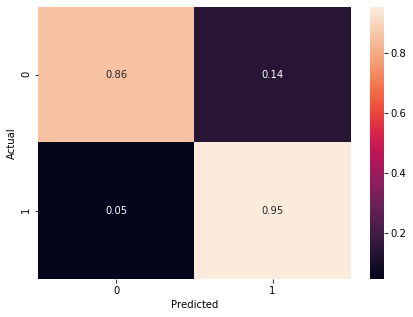

In [164]:
Score_Model(X_test, y_test, model_logreg_stw)
Print_ConfMatrix(X_test, y_test, model_logreg_stw)


In [123]:
logreg_vect_stw = model_logreg_stw.get_params()['vect']
logreg_clf_stw = model_logreg_stw.get_params()['clf']

# get the feature names as numpy array
feature_names_stw = np.array(logreg_vect_stw.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = logreg_clf_stw.coef_[0].argsort()

# Find the 20 smallest and 20 largest coefficients
# The 20 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names_stw[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names_stw[sorted_coef_index[:-21:-1]]))

Smallest Coefs:
['edes' 'sitten' 'mitään' 'huono' 'ei' 'surkea' 'olisi' 'juoni'
 'ilmeisesti' 'ihan' 'että' 'jos' 'vain' 'pahasti' 'minkäänlaista'
 'oikein' 'miksi' 'sentään' 'tylsä' 'valitettavasti']

Largest Coefs: 
['ja' 'myös' 'hyvin' 'hän' 'loistava' 'hieman' 'tekee' 'sekä' 'joka'
 'paras' 'elokuva' 'silti' 'hienosti' 'hänen' 'loistavasti' 'kaikille'
 'vaikka' 'ehdottomasti' 'toimii' 'hieno']


# Naive Bayes models

## Multinomial Naive Bayes

In [103]:
from sklearn import naive_bayes
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

model_MNB = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), min_df = 10, stop_words=stoplist)),
#                      ('tfidf', TfidfTransformer()),
                     ('clf', naive_bayes.MultinomialNB(alpha=0.5)),
                    ]) 
model_MNB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['valmiiksi', 'viedä', 'etsivät',
                                             'pysymään', 'tehtäväkseen',
                                             'suuret', 'hahmolta', 'näkyviss...
                                             'koituu', 'laajentaa', 'veljeään',
                                             'omillaan', 'tehostaa', 'puuttui',
                                             'loppuen', 'versiot',
                                             'vertailemaan', 'kulttuurista',
     

Mean accuracy : 0.946
ROC-AUC score : 0.972


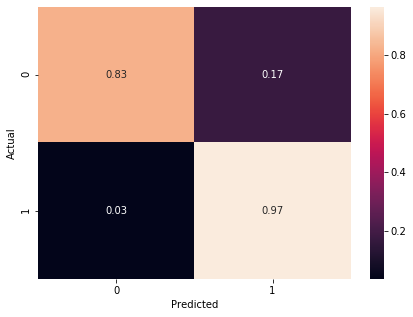

In [118]:
Score_Model(X_test, y_test, model_MNB)
Print_ConfMatrix(X_test, y_test, model_MNB)


In [ ]:
predict = model_MNB.predict(['tosi surkea'])
predict



## Complement Naive bayes

In [176]:
model_CNB = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), min_df = 10, stop_words=stoplist[-1300:-1])),
#                      ('tfidf', TfidfTransformer()),
                     ('clf', naive_bayes.ComplementNB(alpha=0.5)),
                    ]) 
model_CNB.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=10,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=['ylä', 'edelleenkään', 'sormensa',
                                             'vanhempaa', 'synny',
                                             'ihmettelemään', 'käänteistä',
                                             'maa...
                                             'nenän', 'goldsmithin', 'nuoriso',
                                             'sopinut', 'tajusin', 'paukkuu',
                                             'nautinnollista', 'kontrastia',
                             

Mean accuracy : 0.944
ROC-AUC score : 0.972


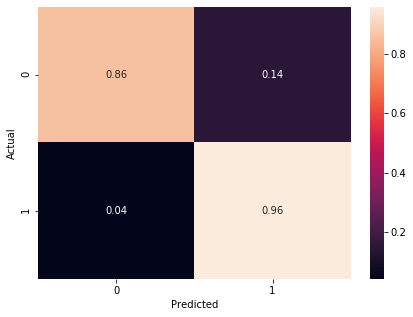

In [177]:
Score_Model(X_test, y_test, model_CNB)
Print_ConfMatrix(X_test, y_test, model_CNB)



## Feature importance

In [1]:
def top_n_features(n, clf, vectorizer):
    class_0_prob_sorted = (-clf.feature_log_prob_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    class_1_prob_sorted = (-clf.feature_log_prob_[1, :]).argsort()
    
    class_0_features = np.take(vectorizer.get_feature_names(), class_0_prob_sorted[:n])
    class_1_features = np.take(vectorizer.get_feature_names(), class_1_prob_sorted[:n])
     
    print("The top {} most important features of class 1 :\n".format(n))
    print(class_1_features)
    
    print("\nThe top {} most important features from class 0 :\n".format(n))
    print(class_0_features)
    
